## 1-hidden and 2-hidden layer ReLU NN vs. linear NN
Empirically comparing the **full** Hessian of the l2 loss function of a linear NN with a ReLU NN

Since the Hessian has the dimensions $\mathbf{H} \in \mathbb{R}^{p \times p}$, where $p$ is the total nummber of parameters, this empirical comparison is only possible for fairly small networks.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
import time
from IPython.display import display, Latex

from torch.distributions.multivariate_normal import MultivariateNormal
from datetime import datetime

In [ ]:
torch.set_default_dtype(torch.float64)

In [2]:
# Create model of linear NN with L hidden layers
# input dim = d, hidden dim = m, output dim = k
class Linear_NN(nn.Module):
    def __init__(self,d,m,k,L):
        """
            d: input dimension
            m: hidden layer dimension 
            k: output dimension
            L: number of hidden layers
        """
        super().__init__()
        
        self.L = L
        self.lin_out = nn.Linear(m, k, bias=False)
        self.lin_in = nn.Linear(d, m, bias=False)
        
        self.lin_hidden = nn.ModuleList([nn.Linear(m, m, bias=False) for i in range(self.L)])
        
        
    def forward(self, xb):
        xb = self.lin_in(xb)
        
        for i in range(self.L):
            xb = self.lin_hidden[i](xb)
            
        xb = self.lin_out(xb)
        
        return xb
    
    def init_weights(self, init_type):
        if init_type == 'kaiming_normal':
            torch.nn.init.kaiming_normal_(self.lin_in.weight, nonlinearity='linear')
            torch.nn.init.kaiming_normal_(self.lin_out.weight, nonlinearity='linear')
            for i in range(self.L):
                torch.nn.init.kaiming_normal_(self.lin_hidden[i].weight, nonlinearity='linear')
        elif init_type == 'kaiming_uniform':
            torch.nn.init.kaiming_uniform_(self.lin_in.weight, nonlinearity='linear')
            torch.nn.init.kaiming_uniform_(self.lin_out.weight, nonlinearity='linear')
            for i in range(self.L):
                torch.nn.init.kaiming_uniform_(self.lin_hidden[i].weight, nonlinearity='linear')
        elif init_type == 'xavier_normal':
            torch.nn.init.xavier_normal_(self.lin_in.weight)
            torch.nn.init.xavier_normal_(self.lin_out.weight)
            for i in range(self.L):
                torch.nn.init.xavier_normal_(self.lin_hidden[i].weight)
        elif init_type == 'xavier_uniform':
            torch.nn.init.xavier_uniform_(self.lin_in.weight, nonlinearity='linear')
            torch.nn.init.xavier_uniform_(self.lin_out.weight, nonlinearity='linear')
            for i in range(self.L):
                torch.nn.init.xavier_uniform_(self.lin_hidden[i].weight, nonlinearity='linear')
        else:
            print('Unknown initialization. Using Kaiming normal initialization')
            torch.nn.init.kaiming_normal_(self.lin1.weight, nonlinearity='linear')
            torch.nn.init.kaiming_normal_(self.lin2.weight, nonlinearity='linear')
            for i in range(self.L):
                torch.nn.init.kaiming_normal_(self.lin_hidden[i].weight, nonlinearity='linear')

In [3]:
# Create model of linear NN with L hidden layers
# input dim = d, hidden dim = m, output dim = k
class ReLU_NN(nn.Module):
    def __init__(self,d,m,k,L):
        """
            d: input dimension
            m: hidden layer dimension 
            k: output dimension
            L: number of hidden layers
        """
        super().__init__()
        
        self.L = L
        self.relu = nn.ReLU()
        self.lin_out = nn.Linear(m, k, bias=False)
        self.lin_in = nn.Linear(d, m, bias=False)
        
        self.lin_hidden = nn.ModuleList([nn.Linear(m, m, bias=False) for i in range(self.L)])
        
        self.sequential = nn.Sequential(self.lin_in)
        
        for i in range(self.L):
            self.sequential.append(self.relu)
            self.sequential.append(self.lin_hidden[i])
        
        self.sequential.append(self.relu)
        self.sequential.append(self.lin_out)                
        
        
    def forward(self, xb):
#         xb = self.lin_in(xb)
                
#         for i in range(self.L):
#             xb = self.relu(xb)
            
#             xb = self.lin_hidden[i](xb)
        
#         xb = self.relu(xb)
                        
#         xb = self.lin_out(xb)
        xb = self.sequential(xb)
        
        return xb
    
    def init_weights(self, init_type):
        if init_type == 'kaiming_normal':
            torch.nn.init.kaiming_normal_(self.lin_in.weight, nonlinearity='linear')
            torch.nn.init.kaiming_normal_(self.lin_out.weight, nonlinearity='linear')
            for i in range(self.L):
                torch.nn.init.kaiming_normal_(self.lin_hidden[i].weight, nonlinearity='linear')
        elif init_type == 'kaiming_uniform':
            torch.nn.init.kaiming_uniform_(self.lin_in.weight, nonlinearity='linear')
            torch.nn.init.kaiming_uniform_(self.lin_out.weight, nonlinearity='linear')
            for i in range(self.L):
                torch.nn.init.kaiming_uniform_(self.lin_hidden[i].weight, nonlinearity='linear')
        elif init_type == 'xavier_normal':
            torch.nn.init.xavier_normal_(self.lin_in.weight)
            torch.nn.init.xavier_normal_(self.lin_out.weight)
            for i in range(self.L):
                torch.nn.init.xavier_normal_(self.lin_hidden[i].weight)
        elif init_type == 'xavier_uniform':
            torch.nn.init.xavier_uniform_(self.lin_in.weight, nonlinearity='linear')
            torch.nn.init.xavier_uniform_(self.lin_out.weight, nonlinearity='linear')
            for i in range(self.L):
                torch.nn.init.xavier_uniform_(self.lin_hidden[i].weight, nonlinearity='linear')
        else:
            print('Unknown initialization. Using Kaiming normal initialization')
            torch.nn.init.kaiming_normal_(self.lin1.weight, nonlinearity='linear')
            torch.nn.init.kaiming_normal_(self.lin2.weight, nonlinearity='linear')
            for i in range(self.L):
                torch.nn.init.kaiming_normal_(self.lin_hidden[i].weight, nonlinearity='linear')

In [1]:
d = 5 # input dimension
m1 = [1,2,5,8,10,20,30,50] # hidden layer dimension
k = 5 # output dimension
L = [0] # number of hidden layers of dim "m"
    
m_L_config = [] # keep track of the network configuration
num_param = [] # count the number of parameters in the model
Linear_Networks = [] # list of NN with different configurations
ReLU_Networks = [] # list of ReLU NN with different configurations


# initiate linear networks of given depth L[l] with m1 hidden units each
for m in m1:
    for l in L:
        m_L_config.append((m,l))
        Linear_Networks.append(Linear_NN(d,m,k,l))
        ReLU_Networks.append(ReLU_NN(d,m,k,l))
        num_param.append(sum(p.numel() for p in Linear_NN(d,m,k,l).parameters()))

NameError: name 'Linear_NN' is not defined

In [ ]:
ReLU_Networks[0].sequential

In [90]:
num_param

[10, 20, 50, 80, 100, 200, 300, 500]

In [91]:
rep = 1000


cov_x = torch.eye(d)

# define multi-variate normal generator with unit matrix as variance
mvrn_d = MultivariateNormal(torch.zeros(d),cov_x)
mvrn_k = MultivariateNormal(torch.zeros(k),torch.eye(k))

# sample n (input,output) tuples
n = 10000
x = mvrn_d.rsample((n,))    
y = mvrn_k.rsample((n,))

# calculate the empirical input covariance matrix and its condition number
cov_xx = x.T @ x / n


H_cond_lin = []
H_o_tilde_cond_lin = []
H_spec_lin = []

H_cond_relu = []
H_spec_relu = []


torch.manual_seed(314159)

for nn_ind in range(len(Linear_Networks)): 
        print('Network configurations: d = %d, k = %d, m = %d, L = %d ' %(d, k, m_L_config[nn_ind][0], m_L_config[nn_ind][1]))
        # repeat the calculation at initialization for rep times
 
        _H_cond_lin = []
        _H_o_tilde_cond_lin = []
        _H_spec_lin = []
        
        for i in range(rep):
            
            if i % 20 == 0:
                print('iter: %d' %i)
            

            # initialize the weight matrices according to the defined initialization
            Linear_Networks[nn_ind].init_weights('kaiming_normal')
            
            V_kaiming = Linear_Networks[nn_ind].lin_in.weight.detach()
            W_kaiming = Linear_Networks[nn_ind].lin_out.weight.detach()

            # calculate the outer Hessian product according to the expression derived by Sidak
            H_o_tilde_lin = torch.kron( W_kaiming @ W_kaiming.T, cov_xx ) + \
                            torch.kron( torch.eye(k), V_kaiming.T @ V_kaiming @ cov_xx )
            _H_o_tilde_cond_lin.append(torch.linalg.cond(H_o_tilde_lin))


            # calculate the prediction at initialization with kaiming or xavier initialization(no training)
            y_hat_lin = Linear_Networks[nn_ind](x)

            # calculate the MSE given the prediction and the loss
            loss_lin = ((y_hat_lin - y)**2).mean()

            # Allocate Hessian size
            H_lin = torch.zeros((num_param[nn_ind], num_param[nn_ind]))

            # Calculate Jacobian w.r.t. model parameters
            J_lin = torch.autograd.grad(loss_lin, list(Linear_Networks[nn_ind].parameters()), create_graph=True)
            J_lin = torch.cat([e.flatten() for e in J_lin]) # flatten

            # Fill in Hessian
            for i in range(num_param[nn_ind]):
                result = torch.autograd.grad(J_lin[i], list(Linear_Networks[nn_ind].parameters()), retain_graph=True)
                H_lin[i] = torch.cat([r.flatten() for r in result]) # flatten

            _H_cond_lin.append(torch.linalg.cond(H_lin.detach()))
            _H_spec_lin += list(torch.linalg.eigvalsh(H_lin.detach()))
            
#             del H_lin, J_lin           
            
        H_o_tilde_cond_lin.append(_H_o_tilde_cond_lin)  
        H_cond_lin.append(_H_cond_lin)        
        H_spec_lin.append(_H_spec_lin)
        
        
        
torch.manual_seed(314159)

for nn_ind in range(len(Linear_Networks)): 
        print('Network configurations: d = %d, k = %d, m = %d, L = %d ' %(d, k, m_L_config[nn_ind][0], m_L_config[nn_ind][1]))
        # repeat the calculation at initialization for rep times
        
        _H_cond_relu = []
        _H_spec_relu = []
        
        for i in range(rep):
            
            if i % 20 == 0:
                print('iter: %d' %i)
            

            # initialize the weight matrices according to the defined initialization
            ReLU_Networks[nn_ind].init_weights('kaiming_normal')
 
            # calculate the prediction at initialization with kaiming or xavier initialization(no training)
            y_hat_relu = ReLU_Networks[nn_ind](x)

            # calculate the MSE given the prediction and the loss
            loss_relu = ((y_hat_relu - y)**2).mean()
            
            # Allocate Hessian size
            H_relu = torch.zeros((num_param[nn_ind], num_param[nn_ind]))

            # Calculate Jacobian w.r.t. model parameters
            J_relu = torch.autograd.grad(loss_relu, list(ReLU_Networks[nn_ind].parameters()), create_graph=True)
            J_relu = torch.cat([e.flatten() for e in J_relu]) # flatten

            # Fill in Hessian
            for i in range(num_param[nn_ind]):
                result = torch.autograd.grad(J_relu[i], list(ReLU_Networks[nn_ind].parameters()), retain_graph=True)
                H_relu[i] = torch.cat([r.flatten() for r in result]) # flatten

            _H_cond_relu.append(torch.linalg.cond(H_relu.detach()))
            _H_spec_relu += list(torch.linalg.eigvalsh(H_relu.detach()))

#             del H_relu, J_relu
            
        
        H_cond_relu.append(_H_cond_relu)
        H_spec_relu.append(_H_spec_relu)        
        


Network configurations: d = 5, k = 5, m = 1, L = 0 
iter: 0
iter: 20
iter: 40
iter: 60
iter: 80
iter: 100
iter: 120
iter: 140
iter: 160
iter: 180
iter: 200
iter: 220
iter: 240
iter: 260
iter: 280
iter: 300
iter: 320
iter: 340
iter: 360
iter: 380
iter: 400
iter: 420
iter: 440
iter: 460
iter: 480
iter: 500
iter: 520
iter: 540
iter: 560
iter: 580
iter: 600
iter: 620
iter: 640
iter: 660
iter: 680
iter: 700
iter: 720
iter: 740
iter: 760
iter: 780
iter: 800
iter: 820
iter: 840
iter: 860
iter: 880
iter: 900
iter: 920
iter: 940
iter: 960
iter: 980
Network configurations: d = 5, k = 5, m = 2, L = 0 
iter: 0
iter: 20
iter: 40
iter: 60
iter: 80
iter: 100
iter: 120
iter: 140
iter: 160
iter: 180
iter: 200
iter: 220
iter: 240
iter: 260
iter: 280
iter: 300
iter: 320
iter: 340
iter: 360
iter: 380
iter: 400
iter: 420
iter: 440
iter: 460
iter: 480
iter: 500
iter: 520
iter: 540
iter: 560
iter: 580
iter: 600
iter: 620
iter: 640
iter: 660
iter: 680
iter: 700
iter: 720
iter: 740
iter: 760
iter: 780
iter: 80

Network configurations: d = 5, k = 5, m = 50, L = 0 
iter: 0
iter: 20
iter: 40
iter: 60
iter: 80
iter: 100
iter: 120
iter: 140
iter: 160
iter: 180
iter: 200
iter: 220
iter: 240
iter: 260
iter: 280
iter: 300
iter: 320
iter: 340
iter: 360
iter: 380
iter: 400
iter: 420
iter: 440
iter: 460
iter: 480
iter: 500
iter: 520
iter: 540
iter: 560
iter: 580
iter: 600
iter: 620
iter: 640
iter: 660
iter: 680
iter: 700
iter: 720
iter: 740
iter: 760
iter: 780
iter: 800
iter: 820
iter: 840
iter: 860
iter: 880
iter: 900
iter: 920
iter: 940
iter: 960
iter: 980


In [92]:
m_L_config

[(1, 0), (2, 0), (5, 0), (8, 0), (10, 0), (20, 0), (30, 0), (50, 0)]

m = 1, L = 0
m = 2, L = 0
m = 5, L = 0
m = 8, L = 0
m = 10, L = 0
m = 20, L = 0
m = 30, L = 0
m = 50, L = 0


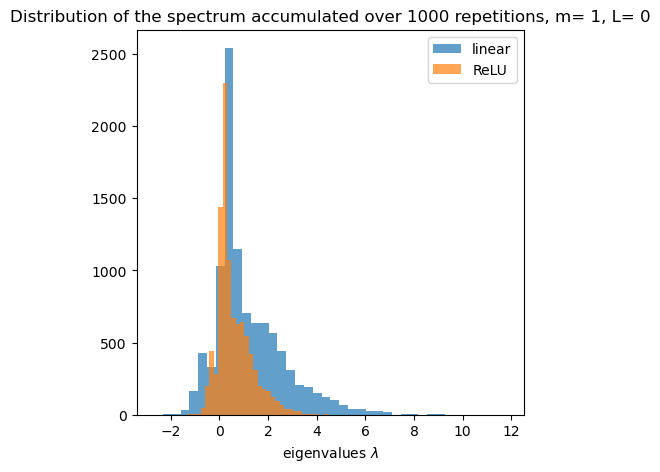

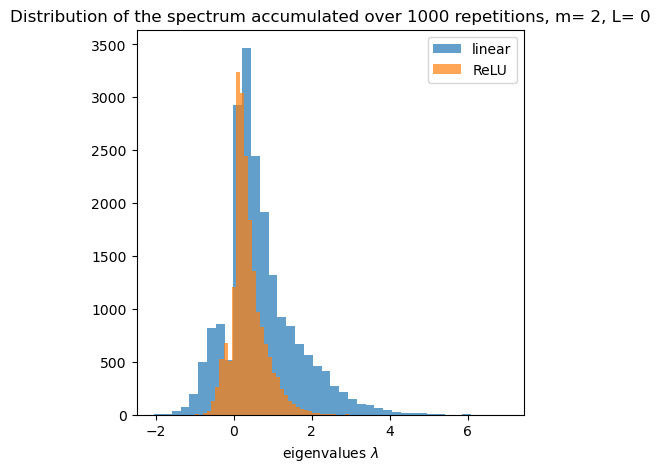

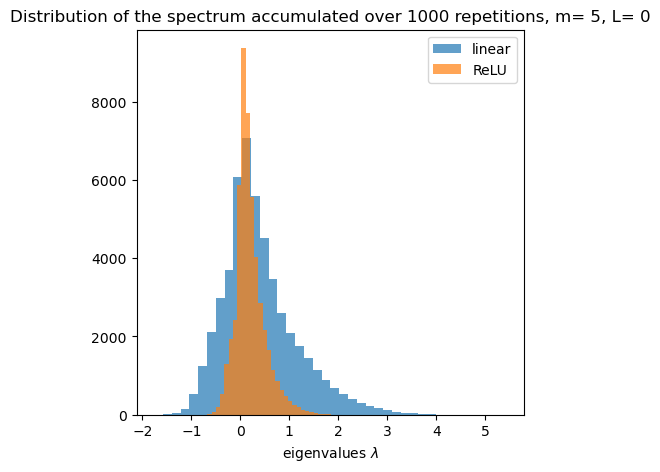

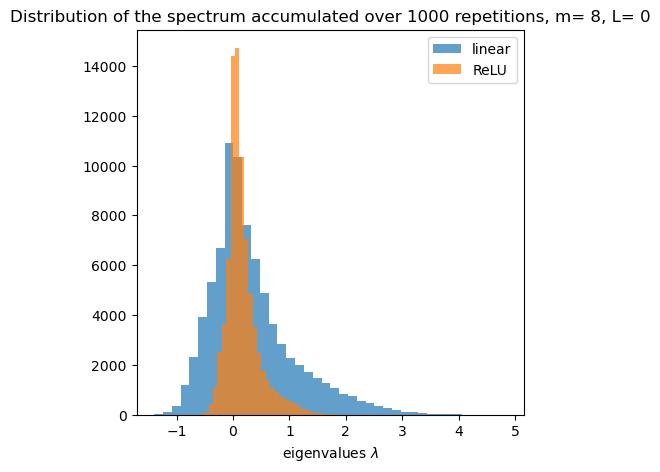

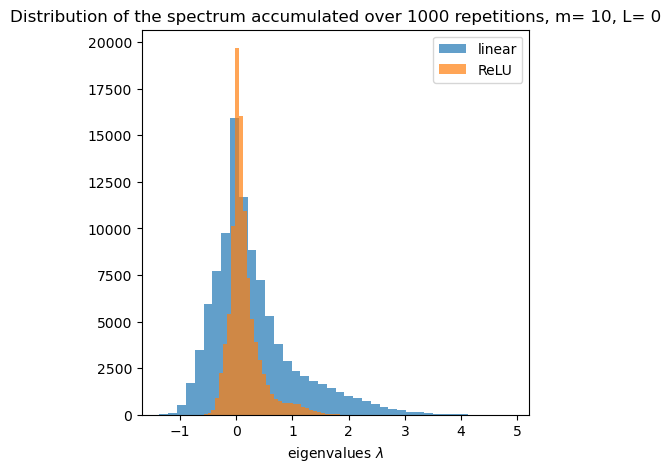

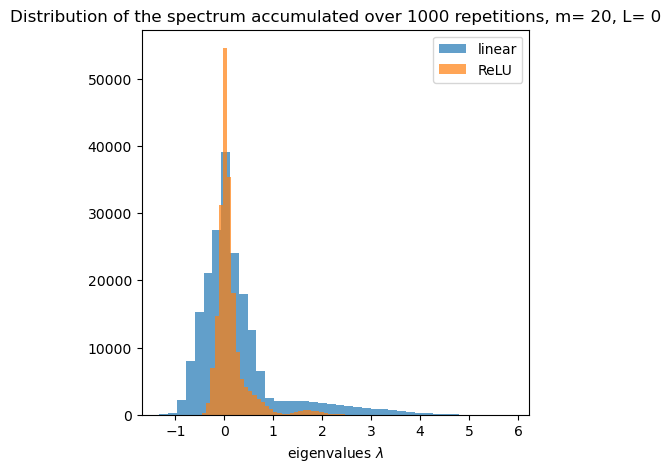

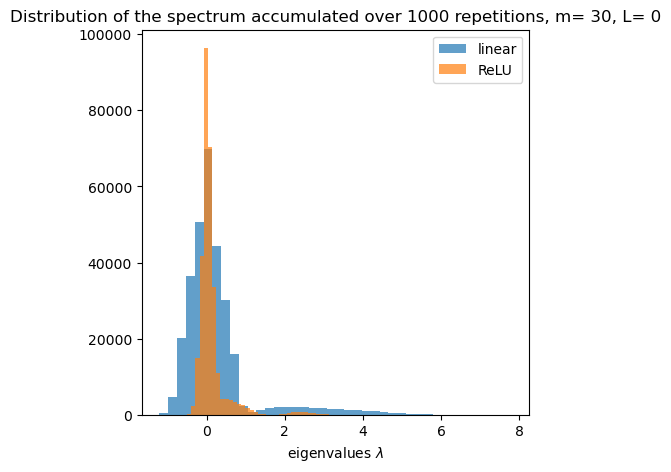

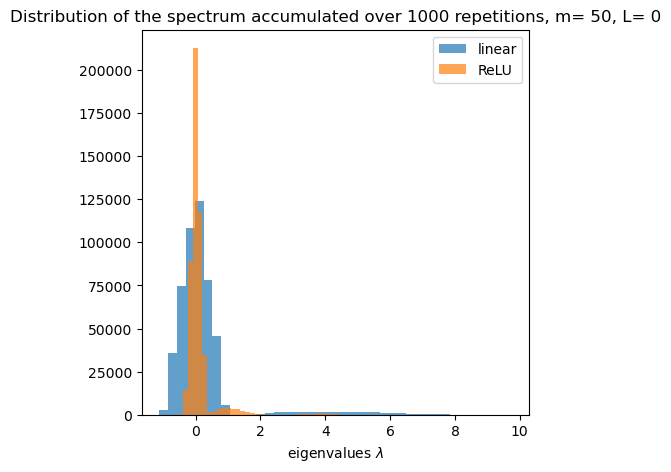

In [93]:
for i in range(len(m_L_config)):
    print('m = %d, L = %d' % (m_L_config[i][0], m_L_config[i][1]))

    plt.figure(figsize=(5,5))
    plt.hist(H_spec_lin[i],bins=40,alpha=0.7, label='linear')
    plt.hist(H_spec_relu[i],bins=40, alpha = 0.7, label='ReLU')
    
    plt.legend()
#     plt.yscale('log')

    plt.title('Distribution of the spectrum accumulated over %d repetitions, m= %d, L= %d' 
              %(rep, m_L_config[i][0], m_L_config[i][1]))
    plt.xlabel('eigenvalues $\lambda$')

m = 1, L = 0
m = 2, L = 0
m = 5, L = 0
m = 8, L = 0
m = 10, L = 0
m = 20, L = 0
m = 30, L = 0
m = 50, L = 0


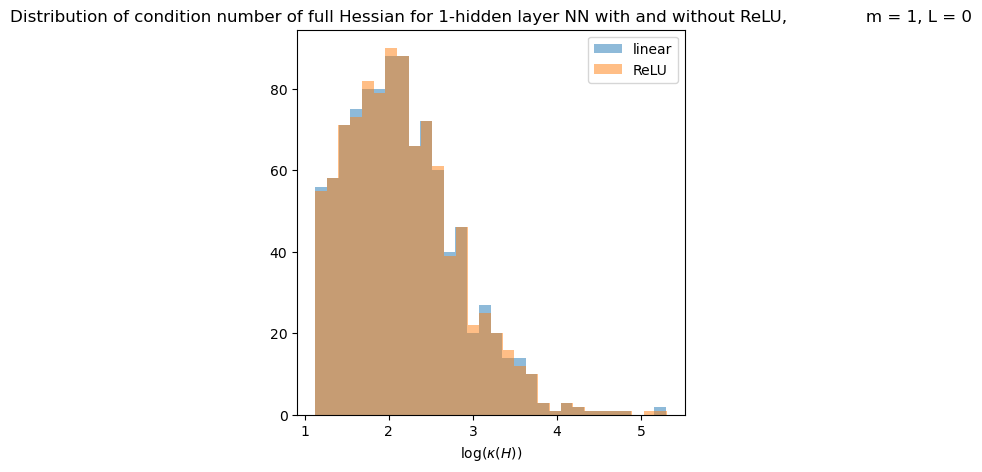

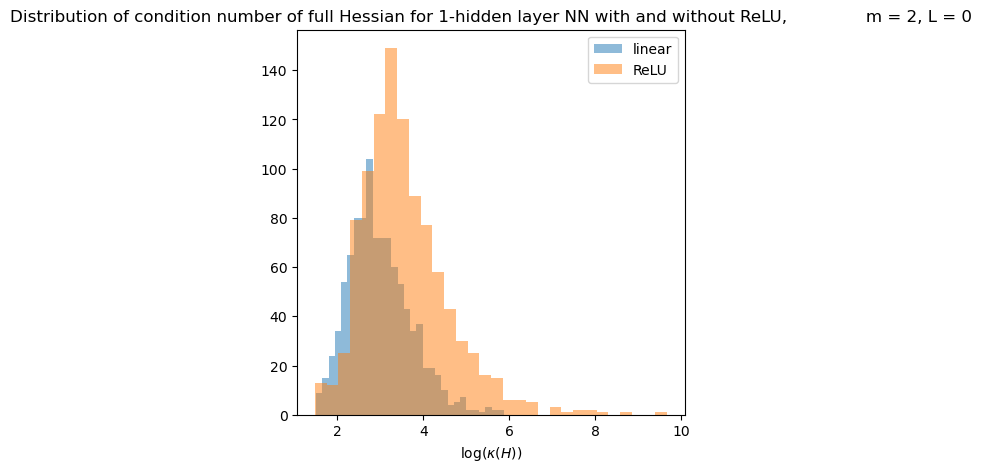

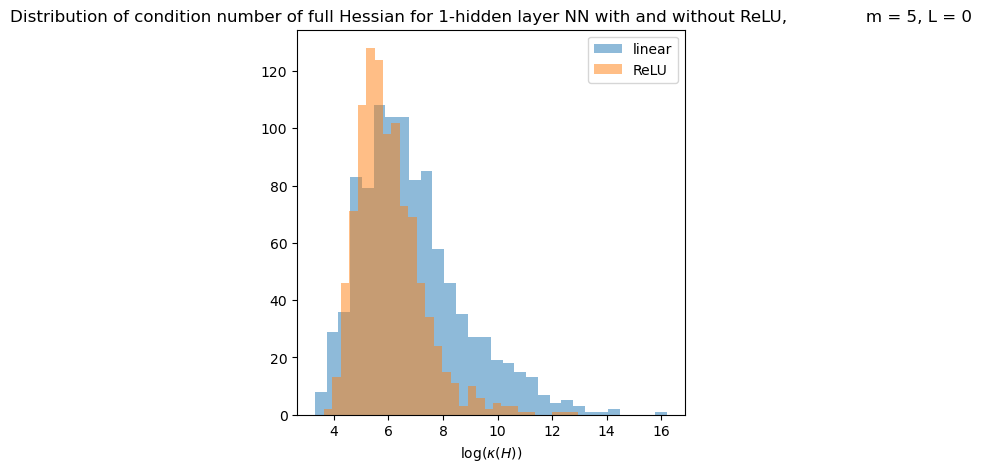

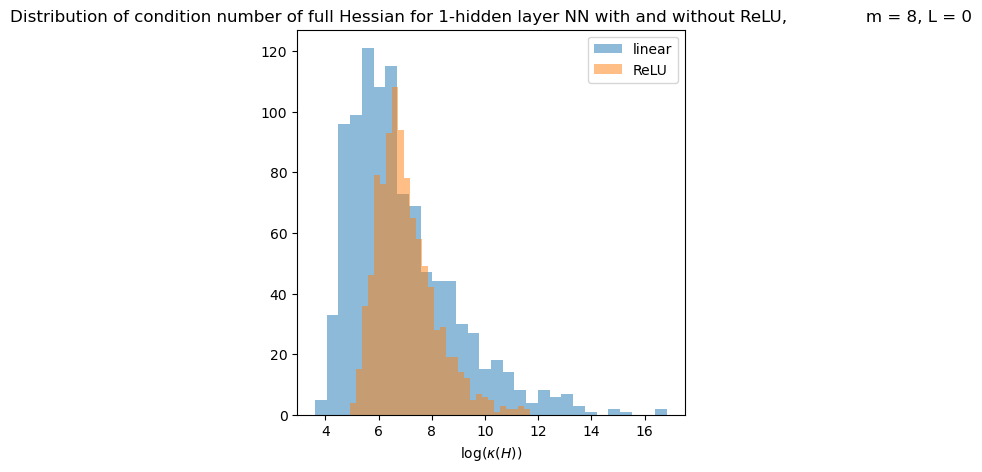

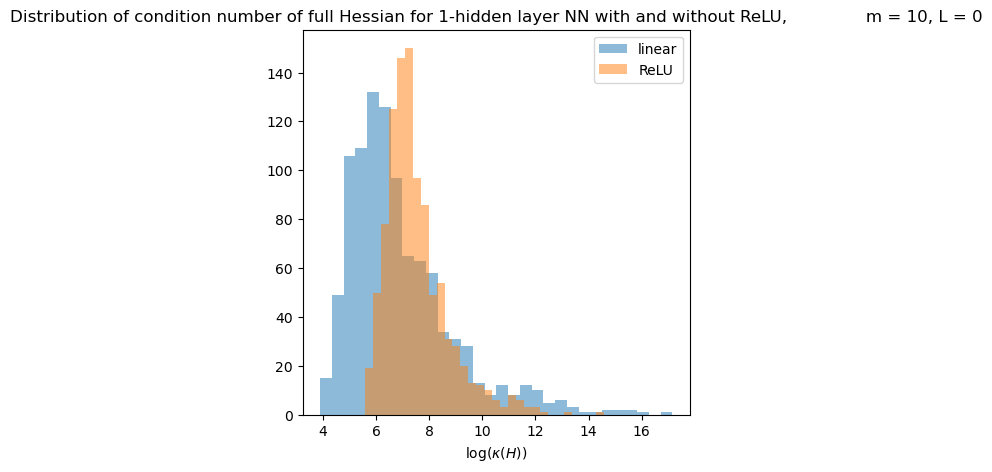

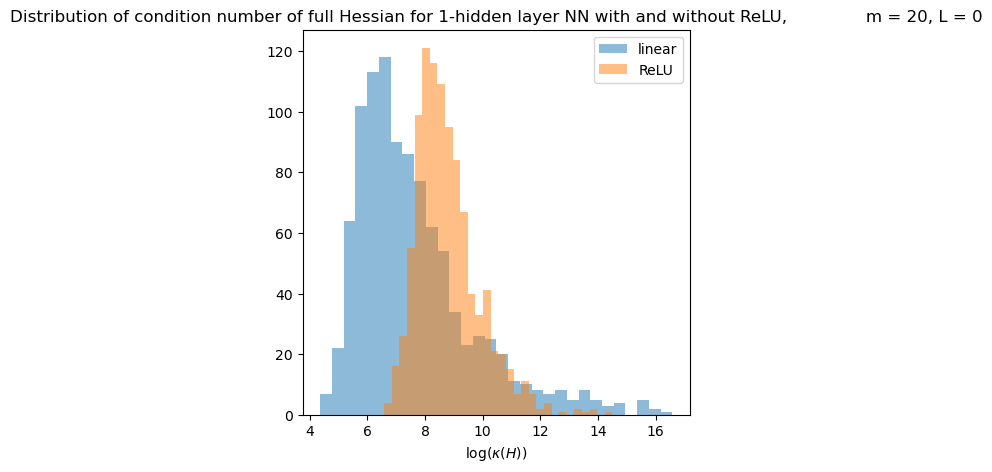

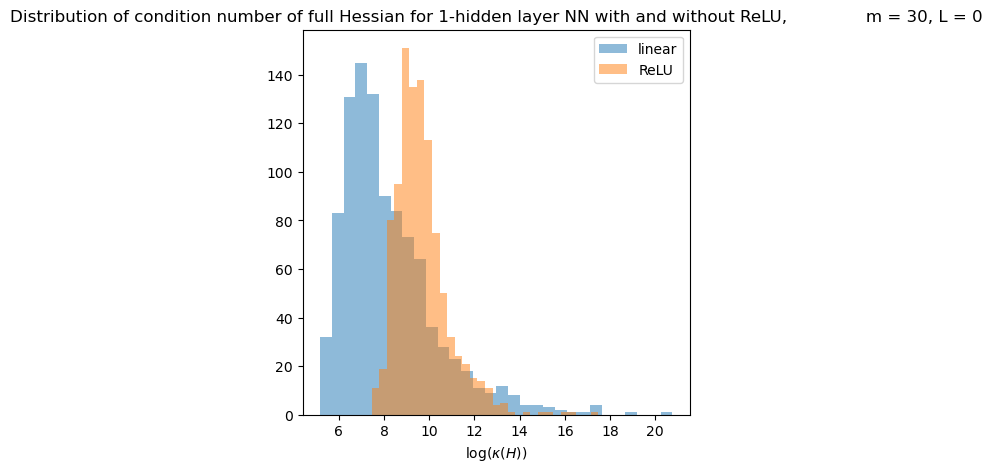

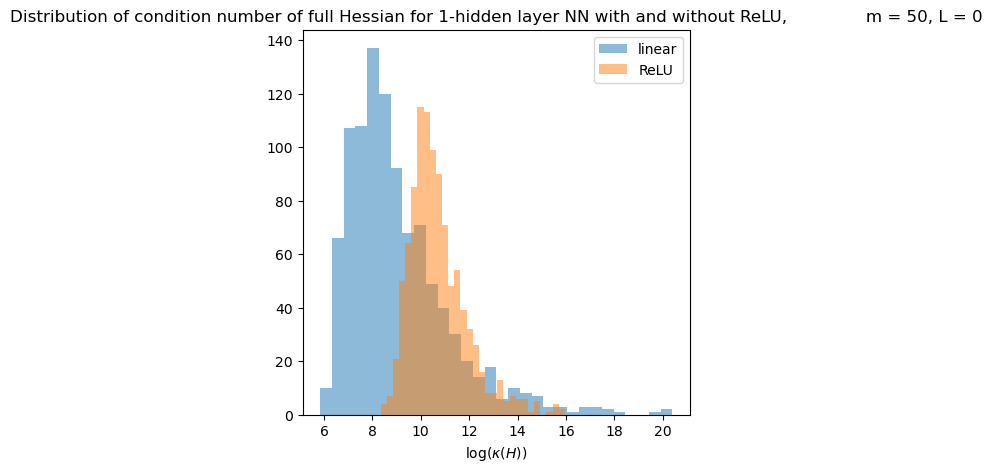

In [94]:
for i in range(len(m_L_config)):
    print('m = %d, L = %d' % (m_L_config[i][0], m_L_config[i][1]))
    
    plt.figure(figsize=(5,5))
    
    plt.hist(np.log(H_cond_lin[i]), bins=30, label='linear', alpha = 0.5)
    plt.hist(np.log(H_cond_relu[i]), bins=30, label='ReLU', alpha = 0.5)

    plt.title('Distribution of condition number of full Hessian for 1-hidden layer NN with and without ReLU, \
              m = %d, L = %d' % (m_L_config[i][0], m_L_config[i][1]) )
    plt.xlabel('$\log(\kappa({H}))$')

    plt.legend()

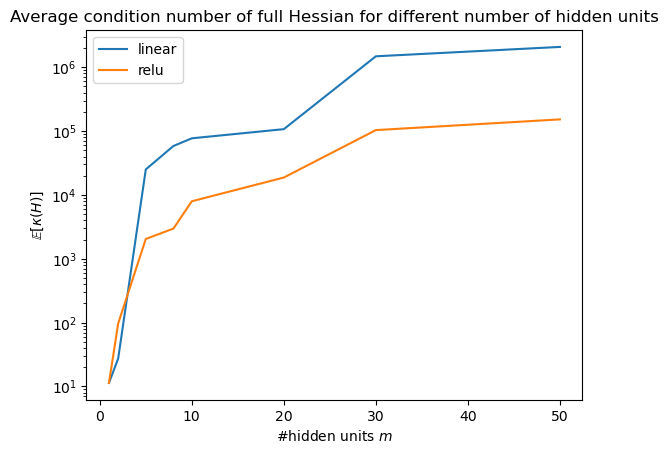

In [95]:
plt.semilogy(m1,[np.mean(H_cond_lin[i]) for i in range(len(m_L_config))], label='linear')
plt.semilogy(m1,[np.mean(H_cond_relu[i]) for i in range(len(m_L_config))], label='relu')

plt.title('Average condition number of full Hessian for different number of hidden units')
plt.ylabel('$\mathbb{E}[\kappa(H)]$')
plt.xlabel('#hidden units $m$')
plt.legend()

### Varying the number of hidden layers while keeping the number of hidden units fixed

In [97]:
d = 5 # input dimension
m1 = [1,5,10] # hidden layer dimension
k = 5 # output dimension
L = [0,1,2,3,5] # number of hidden layers of dim "m"
    
m_L_config = [] # keep track of the network configuration
num_param = [] # count the number of parameters in the model
Linear_Networks = [] # list of NN with different configurations
ReLU_Networks = [] # list of ReLU NN with different configurations


# initiate linear networks of given depth L[l] with m1 hidden units each
for l in L:
    for m in m1:
        m_L_config.append((m,l))
        Linear_Networks.append(Linear_NN(d,m,k,l))
        ReLU_Networks.append(ReLU_NN(d,m,k,l))
        num_param.append(sum(p.numel() for p in Linear_NN(d,m,k,l).parameters()))

In [98]:
ReLU_Networks[0].sequential

Sequential(
  (0): Linear(in_features=5, out_features=1, bias=False)
  (1): ReLU()
  (2): Linear(in_features=1, out_features=5, bias=False)
)

In [99]:
num_param

[10, 50, 100, 11, 75, 200, 12, 100, 300, 13, 125, 400, 15, 175, 600]

In [100]:
rep = 200


cov_x = torch.eye(d)

# define multi-variate normal generator with unit matrix as variance
mvrn_d = MultivariateNormal(torch.zeros(d),cov_x)
mvrn_k = MultivariateNormal(torch.zeros(k),torch.eye(k))

# sample n (input,output) tuples
n = 10000
x = mvrn_d.rsample((n,))    
y = mvrn_k.rsample((n,))

# calculate the empirical input covariance matrix and its condition number
cov_xx = x.T @ x / n


H_cond_lin = []
H_o_tilde_cond_lin = []
H_spec_lin = []

H_cond_relu = []
H_spec_relu = []

# W_11 = 
# W_21 =

# W_12 = 
# W_22 =

torch.manual_seed(314159)

print('Calculations for Linear networks...')

for nn_ind in range(len(Linear_Networks)): 
        print('Network configurations: d = %d, k = %d, m = %d, L = %d ' %(d, k, m_L_config[nn_ind][0], m_L_config[nn_ind][1]))
        # repeat the calculation at initialization for rep times
 
        _H_cond_lin = []
        _H_o_tilde_cond_lin = []
        _H_spec_lin = []
        
        for i in range(rep):
            
            if i % 20 == 0:
                print('iter: %d' %i)
            

            # initialize the weight matrices according to the defined initialization
            Linear_Networks[nn_ind].init_weights('kaiming_normal')
            
            V_kaiming = Linear_Networks[nn_ind].lin_in.weight.detach()
            W_kaiming = Linear_Networks[nn_ind].lin_out.weight.detach()

            # calculate the outer Hessian product according to the expression derived by Sidak
            H_o_tilde_lin = torch.kron( W_kaiming @ W_kaiming.T, cov_xx ) + \
                            torch.kron( torch.eye(k), V_kaiming.T @ V_kaiming @ cov_xx )
            _H_o_tilde_cond_lin.append(torch.linalg.cond(H_o_tilde_lin))


            # calculate the prediction at initialization with kaiming or xavier initialization(no training)
            y_hat_lin = Linear_Networks[nn_ind](x)

            # calculate the MSE given the prediction and the loss
            loss_lin = ((y_hat_lin - y)**2).mean()

            # Allocate Hessian size
            H_lin = torch.zeros((num_param[nn_ind], num_param[nn_ind]))

            # Calculate Jacobian w.r.t. model parameters
            J_lin = torch.autograd.grad(loss_lin, list(Linear_Networks[nn_ind].parameters()), create_graph=True)
            J_lin = torch.cat([e.flatten() for e in J_lin]) # flatten

            # Fill in Hessian
            for i in range(num_param[nn_ind]):
                result = torch.autograd.grad(J_lin[i], list(Linear_Networks[nn_ind].parameters()), retain_graph=True)
                H_lin[i] = torch.cat([r.flatten() for r in result]) # flatten

            _H_cond_lin.append(torch.linalg.cond(H_lin.detach()))
            _H_spec_lin += list(torch.linalg.eigvalsh(H_lin.detach()))
            
#             del H_lin, J_lin           
            
        H_o_tilde_cond_lin.append(_H_o_tilde_cond_lin)  
        H_cond_lin.append(_H_cond_lin)        
        H_spec_lin.append(_H_spec_lin)
        
        
        
torch.manual_seed(314159)

print('Calculations for ReLU networks...')

for nn_ind in range(len(ReLU_Networks)): 
        print('Network configurations: d = %d, k = %d, m = %d, L = %d ' %(d, k, m_L_config[nn_ind][0], m_L_config[nn_ind][1]))
        # repeat the calculation at initialization for rep times
        
        _H_cond_relu = []
        _H_spec_relu = []
        
        for i in range(rep):
            
            if i % 20 == 0:
                print('iter: %d' %i)
            

            # initialize the weight matrices according to the defined initialization
            ReLU_Networks[nn_ind].init_weights('kaiming_normal')
 
            # calculate the prediction at initialization with kaiming or xavier initialization(no training)
            y_hat_relu = ReLU_Networks[nn_ind](x)

            # calculate the MSE given the prediction and the loss
            loss_relu = ((y_hat_relu - y)**2).mean()
            
            # Allocate Hessian size
            H_relu = torch.zeros((num_param[nn_ind], num_param[nn_ind]))

            # Calculate Jacobian w.r.t. model parameters
            J_relu = torch.autograd.grad(loss_relu, list(ReLU_Networks[nn_ind].parameters()), create_graph=True)
            J_relu = torch.cat([e.flatten() for e in J_relu]) # flatten

            # Fill in Hessian
            for i in range(num_param[nn_ind]):
                result = torch.autograd.grad(J_relu[i], list(ReLU_Networks[nn_ind].parameters()), retain_graph=True)
                H_relu[i] = torch.cat([r.flatten() for r in result]) # flatten

            _H_cond_relu.append(torch.linalg.cond(H_relu.detach()))
            _H_spec_relu += list(torch.linalg.eigvalsh(H_relu.detach()))

#             del H_relu, J_relu
            
        
        H_cond_relu.append(_H_cond_relu)
        H_spec_relu.append(_H_spec_relu)        
        


Calculations for Linear networks...
Network configurations: d = 5, k = 5, m = 1, L = 0 
iter: 0
iter: 20
iter: 40
iter: 60
iter: 80
iter: 100
iter: 120
iter: 140
iter: 160
iter: 180
Network configurations: d = 5, k = 5, m = 5, L = 0 
iter: 0
iter: 20
iter: 40
iter: 60
iter: 80
iter: 100
iter: 120
iter: 140
iter: 160
iter: 180
Network configurations: d = 5, k = 5, m = 10, L = 0 
iter: 0
iter: 20
iter: 40
iter: 60
iter: 80
iter: 100
iter: 120
iter: 140
iter: 160
iter: 180
Network configurations: d = 5, k = 5, m = 1, L = 1 
iter: 0
iter: 20
iter: 40
iter: 60
iter: 80
iter: 100
iter: 120
iter: 140
iter: 160
iter: 180
Network configurations: d = 5, k = 5, m = 5, L = 1 
iter: 0
iter: 20
iter: 40
iter: 60
iter: 80
iter: 100
iter: 120
iter: 140
iter: 160
iter: 180
Network configurations: d = 5, k = 5, m = 10, L = 1 
iter: 0
iter: 20
iter: 40
iter: 60
iter: 80
iter: 100
iter: 120
iter: 140
iter: 160
iter: 180
Network configurations: d = 5, k = 5, m = 1, L = 2 
iter: 0
iter: 20
iter: 40
iter: 60

In [101]:
m_L_config

[(1, 0),
 (5, 0),
 (10, 0),
 (1, 1),
 (5, 1),
 (10, 1),
 (1, 2),
 (5, 2),
 (10, 2),
 (1, 3),
 (5, 3),
 (10, 3),
 (1, 5),
 (5, 5),
 (10, 5)]

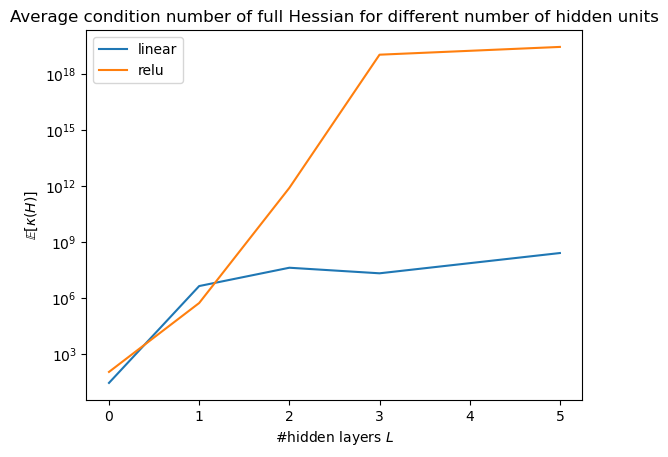

In [67]:
plt.semilogy(L,[np.mean(H_cond_lin[i]) for i in range(len(L))], label='linear')
plt.semilogy(L,[np.mean(np.array(H_cond_relu[i])[np.isfinite(H_cond_relu[i])]) for i in range(len(L))], label='relu')

plt.title('Average condition number of full Hessian for different number of hidden Layers, with %d hidden units' % m1[0])
plt.ylabel('$\mathbb{E}[\kappa(H)]$')
plt.xlabel('#hidden layers $L$')
plt.legend()

In [ ]:
plt.semilogy(L,[np.mean(H_cond_lin[i]) for i in range(len(m1),len(m1)+len(L))], label='linear')
plt.semilogy(L,[np.mean(np.array(H_cond_relu[i])[np.isfinite(H_cond_relu[i])]) for i in range(len(m1),len(m1)+len(L))], label='relu')

plt.title('Average condition number of full Hessian for different number of hidden Layers, with %d hidden units' % m1[1])
plt.ylabel('$\mathbb{E}[\kappa(H)]$')
plt.xlabel('#hidden layers $L$')
plt.legend()

In [ ]:
plt.semilogy(L,[np.mean(H_cond_lin[i]) for i in range(2*len(m1),2*len(m1)+len(L))], label='linear')
plt.semilogy(L,[np.mean(np.array(H_cond_relu[i])[np.isfinite(H_cond_relu[i])]) for i in range(2*len(m1),2*len(m1)+len(L))], label='relu')

plt.title('Average condition number of full Hessian for different number of hidden Layers, with %d hidden units' % m1[2])
plt.ylabel('$\mathbb{E}[\kappa(H)]$')
plt.xlabel('#hidden layers $L$')
plt.legend()